'/home/aistudio'

# 实验名称：车道线检测

## 1 实验简介：

车道线的检测，是无人驾驶中重要的一个环节。本次实验，我们通过计算机视觉的方法，实现车道线的检测。

那么什么是车道线检测呢？我们来看几张图片，就一目了然了。

![](https://ai-studio-static-online.cdn.bcebos.com/72a2b567d1674b35ae231f424cb4eaa125e6ba34b0274e289a4a4be14f9d8cb5)

![](https://ai-studio-static-online.cdn.bcebos.com/a7f1d50a90ee4006bddeb6f05ef7d5635ff3defc0f9943a79896510f0044489e)


我们今天就是要探究一下车道线识别（或称车道线检测）的具体实现过程。


无人驾驶汽车在行驶的时候，摄像头产生的是视频，视频是由一帧帧的图像组成，因此对视频的车道线检测本质上是对图像的车道线进行检测。

本次实验中，车道线识别过程分为以下几个步骤：

①阈值过滤: 设置过滤方案，将车道线从图像中提取出来

②透视变换: 将带有透视现象的图像还原成平面图

③检测车道边线并拟合车道中心线

④计算车辆距离车道中心线的距离和车道当前曲率

## 2 实验目的：

通过本实验，让大家掌握以下知识点：

①车道线检测的原理

②如何从代码上实现：阈值过滤、透视变换、检测车道边线并拟合车道中心线、计算车辆距离车道中心线的距离和车道当前曲率


## 2 实验环境：

python3.5以上 


## 3 实验步骤：



In [1]:
#首先导入必要的库
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### 3.1 阈值过滤


在这一模块，我们会将原始图像进行处理，提取图像中的车道信息。然后进行梯度阈值、颜色阈值处理。

原始图片通过阈值过滤处理后，能够更加清晰的检测出图片中的车道线特征，使小车对车道线的检测性能更加鲁棒，减少受车道线颜色变化、地面光线明暗变化、地面纹理特征变化的影响。

#### 3.1.1 梯度阈值过滤

在梯度阈值处理前，我们要先理解什么是边缘。

**边缘(edge)** 是指图像局部强度变化最显著的部分。主要存在于目标与目标、目标与背景、区域与区域(包括不同色彩)之间，是图像分割、纹理特征和形状特征等图像分析的重要基础。

图像的边缘有方向和幅度两个属性,沿边缘方向像素变化平缓,垂直于边缘方向像素变化剧烈.边缘上的这种变化可以用微分算子检测出来,通常用一阶或二阶导数来检测边缘。

而对于车道线来说，车道线的颜色通常与路面有较大差异，所以，我们可以利用路面到车道线的颜色突变来进行检测。

实际上通过观察可以发现，车道线在接近垂直的方向，因此我们可以单独选取x，y两个方向的梯度（边缘）来检测。

Sobel算子根据像素点上下、左右邻点灰度加权差，在边缘处达到极值这一现象检测边缘。对噪声具有平滑作用，提供较为精确的边缘方向信息，边缘定位精度不够高。当对精度要求不是很高时，是一种较为常用的边缘检测方法。

![](https://ai-studio-static-online.cdn.bcebos.com/5b97f52421214525a0c8cbe8a80d9d484f12091ca6d646a49e3ea8759fc16b81)



In [2]:
#我们定义一个梯度阈值过滤的方法，先尝试一下在x方向（或者y方向）来进行操作。
def abs_sobel_thresh(img, orient = 'x', thresh_min = 0, thresh_max = 255):
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 使用cv2.Sobel计算x方向、y方向的导数
    if orient == 'x':
        #利用Sobel方法可以进行sobel边缘检测，cv2.CV_64F表示64位浮点数即64float
        #分别是对X和Y方向的导数（即dx,dy），对于图像来说就是差分，这里1表示对X求偏导（差分），0表示不对Y求导（差分）。其中，X还可以求2次导。
        #对X求导就是检测X方向上是否有边缘。
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))#gray在这里表示源图像，即进行边缘检测的图像
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 阈值过滤
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #创建一个空矩阵，也就是黑图片
    binary_output = np.zeros_like(scaled_sobel)
    #如果梯度在阈值范围内的，图片点亮
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

我们可以用matplotlib输出原图，看看是什么样子；

同时，你也可以用print语句，把原始图片打印一下，看看又是什么；

你将会看到这个样子：

![](https://ai-studio-static-online.cdn.bcebos.com/ae6b12fbc1124dc7af407800270be41082df854565f44acab0cc38a037c941f6)

[[[ 82  81  83]
  [ 79  81  82]
  [ 77  80  84]
  ...
  [234 233 235]
  [234 233 235]
  [234 233 235]]

 [[ 78  80  81]
  [ 78  80  81]
  [ 74  79  82]
  ...
  [234 233 235]
  [234 233 235]
  [234 233 235]]

 [[ 79  81  82]
  [ 78  80  81]
  [ 74  79  80]
  ...
  [234 233 235]
  [234 233 235]
  [234 233 235]]

 ...

 [[106  91  99]
  [ 92  76  83]
  [ 83  68  66]
  ...
  [ 93  78  69]
  [ 96  84  74]
  [103  91  81]]

 [[101  80  82]
  [ 98  78  77]
  [101  80  78]
  ...
  [101  86  77]
  [101  90  82]
  [106  95  87]]

 [[102  77  75]
  [110  85  83]
  [120  98  92]
  ...
  [101  88  80]
  [101  92  83]
  [104  95  86]]]


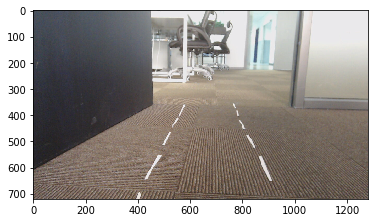

In [4]:
#用opencv读取原图
origin = cv2.imread('work/images/2018-07-28-172202.jpg')
#输出原图
plt.imshow(origin)
#打印出原图的数字矩阵
print(origin)

接下来，在原图的基础上，进行梯度阈值过滤。

我们可以用matplotlib输出梯度过滤后的图，看看是什么样子；

同时，你也可以用print语句，把梯度过滤后的图片打印一下，看看又是什么；

你将会看到这个样子：

![](https://ai-studio-static-online.cdn.bcebos.com/b02fd97d70084e90a6043e56423ed6220a70da7e0016467a89be1e7e0ea1c6cd)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


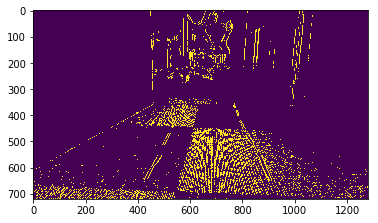

In [5]:
#接下来，在原图的基础上，进行梯度阈值过滤
img = origin.copy()
img_x_thresh = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=200)
print(img_x_thresh)
plt.imshow(img_x_thresh)


接下来，我们再定义一个方法，将两个x/y两个方向的梯度结合起来，进行梯度阈值过滤。

In [6]:
## 然后，我们再定义一个方法，将两个x/y两个方向的梯度结合起来
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

在接下来的模块中，我们通过更改不同的sobel_kernel，来观察不同的效果。

![](https://ai-studio-static-online.cdn.bcebos.com/0a1d7abacf8345978964b8444361c5157e72bc0513db4d4986a891584a7071b0)

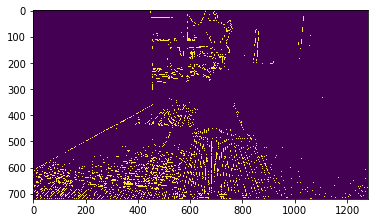

In [7]:
img_1 = origin.copy()
mag_thresh_1 = mag_thresh(img_1, sobel_kernel=3, mag_thresh=(50, 100))
plt.imshow(mag_thresh_1)

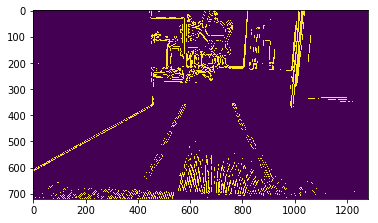

In [8]:
img_2 = origin.copy()
mag_thresh_2 = mag_thresh(img_1, sobel_kernel=27, mag_thresh=(50, 100))
plt.imshow(mag_thresh_2)

#### 3.1.2 颜色阈值过滤

接下来，我们使用不同颜色空间下的不同通道，进行颜色阈值检测。

彩色图片有多种建模表示方法，其中RGB是采用红绿蓝三种颜色来衡量一张彩色图片，是最常见的表示方法之一。此时会出现一个问题，比如车道线是黄色的，那么在R通道下，可以看得清，但在G和B通道下可能就看不清了，因此我们需要其他对图像进行建模和表示的方法，于是就有了LUV（亮度 色度空间），HLS（色相 亮度 饱和度空间），HSV（色相 饱和度 颜色值空间），LAB（亮度，颜色空间）。

![](https://ai-studio-static-online.cdn.bcebos.com/526d82e0969c4623b739493ee2db0c277dadf4b0bc06428ea3b1d9c9500d718f)

In [9]:
def hls_select(img, channel = 's', thresh = (0, 255)):
    #颜色阈变化，将RGB图像转化成HLS图像，
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #根据选择，分别提取hls中的h通道,或l通道,或s通道
    if channel == 'h':
        channel = hls[:, :, 0]
    elif channel == 'l':
        channel = hls[:, :, 1]
    else:
        channel = hls[:, :, 2]
        
    #提取所选通道中符合阈值的像素点
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

接下来，我们调用hls_select方法，提取hls中的l通道，来做颜色阈值检测。

你也可以尝试提取hls中的h通道，看看效果如何。

![](https://ai-studio-static-online.cdn.bcebos.com/a7c396e9424f4587a534d08f38524d7beba7fe7e850341a18a5bc344df8f68c0)

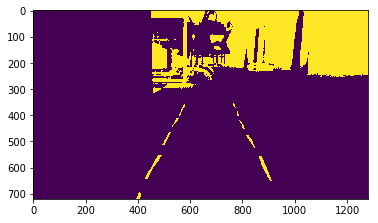

In [12]:
#调用hls_select方法，提取hls中的l通道，来做颜色阈值检测
img_color_value = origin.copy()
s_thresh = hls_select(img,channel='l',thresh=(180, 255))
plt.imshow(s_thresh)

### 3.1.3 组合阈值过滤

我们可以把以上介绍的方式组合起来，进行阈值检测。

![](https://ai-studio-static-online.cdn.bcebos.com/f115c0a3ee754e27b6c324ea77110668dd6a3e264a2440d1aefefbff223dad24)

In [13]:
## 其余几个过滤器（检测器）
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def luv_select(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def lab_select(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output


In [14]:
def thresholding(img):
    x_thresh = abs_sobel_thresh(img, orient='x', thresh_min=10 ,thresh_max=230)
    m_thresh = mag_thresh(img, sobel_kernel=27, mag_thresh=(70, 100))
    dir_thresh = dir_threshold(img, sobel_kernel=27, thresh=(0.7, 1.3))
    hls_thresh = hls_select(img, thresh=(180, 255))
    lab_thresh = lab_select(img, thresh=(155, 200))
    luv_thresh = luv_select(img, thresh=(225, 255))
    # Thresholding combination
    threshholded = np.zeros_like(x_thresh)
    threshholded[((x_thresh == 1) & (m_thresh == 1)) | ((dir_thresh == 1) & (hls_thresh == 1)) | (lab_thresh == 1) | (luv_thresh == 1)] = 1

    return threshholded

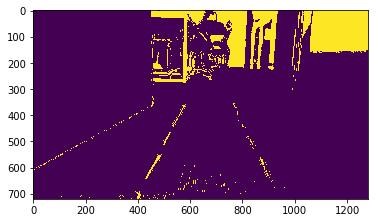

In [15]:
img_combine = origin.copy()
comb_thresh = thresholding(img)
plt.imshow(comb_thresh)

## 4. 透视变换
无论是眼睛、摄像头还是绘画，我们看到的，描绘到的三维世界，总会存在"近大远小"，"近高远低"的透视现象。控制小车沿车道线转弯时，参考的角度应为车道线实际角度，因此我们需要将单目摄像头获取的图像进行透视变换。

透视变换的本质是“映射”，将原图像的像素点按照一定的“比例”映射到另外一张图上。

这个“比例”关系可以通过4个点的映射规律得到，从而推广到图片中的其他像素点。opecv中有函数帮组我们完成这些过程：

**cv2.getPerspectiveTransform(src, dst):**

该函数的输入是原图中的4个点坐标，映射后的4个点的坐标，输出是一个矩阵，也就是这个映射的“比例”关系。原图中的4个点的坐标可以直接利用画图工具，找原图上对应的一个矩形的四个角点，映射后的4个点的坐标是自己定义的，需要不断尝试调整。

![](https://ai-studio-static-online.cdn.bcebos.com/e8f76c1204754ef2b7e2f1d7e414848e9cdc206352264d0ca563c9fddd01759f)

![](https://ai-studio-static-online.cdn.bcebos.com/8909b5b2912a42669f408141c9d80b384c1c843dddc341889a7c2d85bb2ed16a)

In [16]:
# 透视变换，输入为原图和进行阈值检测后的图
# 得到变形矩阵和逆变形矩阵
def get_M_Minv():
    #定义原图中待映射的4个点坐标
    src = np.float32([[(400, 720), (580, 350), (780, 350), (950, 720)]])
    # 定义映射后的4个点的坐标
    dst = np.float32([[(320, 720), (320, 0), (960, 0), (960, 720)]])
    #求映射的关系矩阵
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return [M,Minv]

(720, 1280, 3)
(1280, 720)


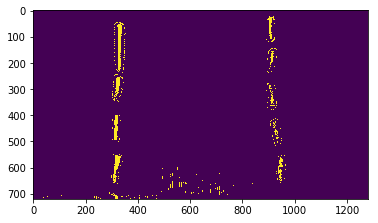

In [17]:
img_pres = origin.copy()
print(img_pres.shape)
print(img_pres.shape[1::-1])

M, Minv = get_M_Minv()
# 输出透视变换后的图片
binary_wraped = cv2.warpPerspective(comb_thresh, M, img_pres.shape[1::-1], flags=cv2.INTER_LINEAR)

plt.imshow(binary_wraped)

## 5. 检测车道边线
以上步骤中，生成的二进制图还存在一定的噪音像素，为了准确检测车道边界，首先要确定哪些像素是属于车道线的。

首先要定位车道线的基点(图片最下方车道出现的x轴坐标)，由于车道线在的像素都集中在x轴一定范围内，因此把图片一分为二，左右两边的在x轴上的像素分布峰值非常有可能就是车道线基点。

定位基点后，再使用使用滑动窗多项式拟合(sliding window polynomial fitting)来获取车道边界。这里使用9个200px宽的滑动窗来定位一条车道线像素：


In [18]:
def find_line(binary_warped):
    # 在底部建立的直方图
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # 观察直方图
    print(histogram.shape)
    plt.plot(range(1280), histogram)
    
    # 找到直方图左右的峰值，这两个峰值可能是车道线
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # 选择窗口的数量
    nwindows = 20
    # 设置窗口到高度
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # 确定图像中所有非零像素的位置
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 更新当前窗口的位置
    leftx_current = leftx_base
    rightx_current = rightx_base
    # 设置窗口的宽度margin
    margin = 150
    # 当一个窗口中非零像素大于minpix时，将他们加入拟合点
    minpix = 20
    # 初始化拟合点位置信息
    left_lane_inds = []
    right_lane_inds = []
    
    # 防止弯道情况的指标初始化
    leftx_empty = 0
    rightx_empty = 0
    # 进行窗口滑动
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # 观察选取的框
        img_show = plt.imshow(binary_wraped)
        currentAxis=plt.gca()
        rect=patches.Rectangle((win_xleft_low, win_y_low), 2*margin, window_height,linewidth=1,edgecolor='r',facecolor='none')
        currentAxis.add_patch(rect)
        
        img_show = plt.imshow(binary_wraped)
        currentAxis=plt.gca()
        rect=patches.Rectangle((win_xright_low, win_y_low), 2*margin, window_height,linewidth=1,edgecolor='r',facecolor='none')
        currentAxis.add_patch(rect)
        
        
        
        # 找到非零像素的位置
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # 将这些值加入list中
        # 如果符合条件，将非零点加入left/right_lane_inds中，并更新窗口
        if len(good_left_inds) > minpix and leftx_empty < 3:
            left_lane_inds.append(good_left_inds)
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if leftx_empty > 0:
                leftx_empty -= 1
        else:
            leftx_empty += 1
            
        if len(good_right_inds) > minpix and rightx_empty < 3:    
            right_lane_inds.append(good_right_inds)
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            if rightx_empty >0:
                rightx_empty -= 1
        else:
            rightx_empty += 1
            
        # print(leftx_current, rightx_current)
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # 提取左右边线位置信息
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # 对左右边线进行拟合
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # 当只能算法将一条车道线识别为两条时，进行分离处理
    d_left = left_fit[0] * 720 **2 + left_fit[1] * 720 + left_fit[2]
    d_right = right_fit[0] * 720 **2 + right_fit[1] * 720 + right_fit[2]
    
    print(d_left, d_right)
    
    if d_right - d_left < 50:
        if (d_left + d_right)/2 <= 640:
            right_fit[2] = left_fit[2] + 600
        else:
            left_fit[2] = right_fit[2] - 600
        
    
    '''
    plt.plot(lefty, leftx, 'o')
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    plt.plot(lefty, left_fitx)
    
    plt.plot(righty, rightx, 'o')
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    plt.plot(righty, right_fitx)
    '''
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

运行下面代码，输出的效果应该如图所示：

![](https://ai-studio-static-online.cdn.bcebos.com/fbb74a24b5eb433788137160fce1219c45b1598976264e15af405923959bcc26)

(1280,)
322.64623840165183 951.2192642524651
[ 8.14793330e-05 -8.08826789e-02  3.38642881e+02] [7.33035312e-05 9.60720851e-03 9.06301524e+02] [12783 12823 12824 ...  1158  1159  1160] [12667 12676 12677 ...   192   193   194]


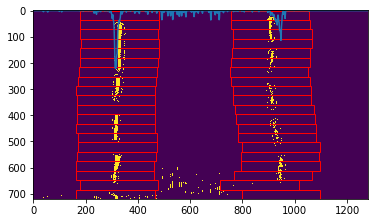

In [19]:
left_fit, right_fit, left_lane_inds, right_lane_inds = find_line(binary_wraped)
print(left_fit, right_fit, left_lane_inds, right_lane_inds)

## 6. 计算车道中心线曲率/车辆距中心线的位置
通过数学计算得到车道中心线的曲率和车辆当前偏离中心线的距离。

根据数学知识可以知道，曲线上某一点的曲率可以通过以下公式计算得到：

![](https://ai-studio-static-online.cdn.bcebos.com/eeb88485bbb5477d9149e635aacd9ec65360ea3fa10e4b05bef432143ee64cc6)

但是通过这个公式，我们求出的车道线曲率是像素级别的，如果要转换到真实世界坐标系下的曲率，需要知道像素与真实世界坐标系尺寸的对应关系，这里直接给出：

![](https://ai-studio-static-online.cdn.bcebos.com/a18e622e76fc4e0e95ae565422beb9ebca6b162bd4cc450ea3d65470b82351ae)

除求出车道线的曲率外，我们还可以知道本车与车道线之间的相对位置关系，即本车与车道线中心的距离。假设摄像头布置在本车的中心，那么图像的中心即为本车的中心，两个车道线的中间点坐标就是车道线中心，从而可以求出两者之间的相对距离。需要说的是，这里求出的是像素级的距离，还需要将其转换到世界坐标下的距离。

In [20]:
def calculate_curv_and_pos(binary_warped, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = ((left_curverad + right_curverad) / 2)
    #print(curvature)
    lane_width = np.absolute(leftx[719] - rightx[719])
    lane_xm_per_pix = 3.7 / lane_width
    veh_pos = (((leftx[719] + rightx[719]) * lane_xm_per_pix) / 2.)
    cen_pos = ((binary_warped.shape[1] * lane_xm_per_pix) / 2.)
    distance_from_center = veh_pos - cen_pos
    return curvature, distance_from_center

In [21]:
curv, dist = calculate_curv_and_pos(binary_wraped, left_fit, right_fit)
print(curv)
print(dist)

2128.3541682850046
-0.01850297712157367


## 7. 在原图上还原车道线

最后，我们在原图上，把车道线画出来，我们主要利用opencv中的fillpoly函数，他可以画出一个矩形，代表车道线的位置：

效果图如下：

![](https://ai-studio-static-online.cdn.bcebos.com/be7452322efa4dc8ac893492879f97ca41cda92dfe574811a46c87e8c063860b)

In [22]:
def draw_area(undist, binary_warped, Minv, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

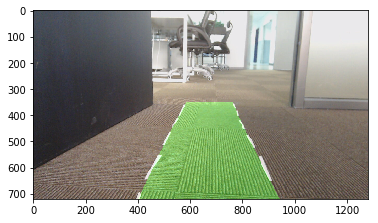

In [23]:
img_result = draw_area(origin, binary_wraped, Minv, left_fit, right_fit)
plt.imshow(img_result)

## 8. 实验总结：

至此，我们的车道线检测试验做完了，通过本次实验，我们了解了车道线检测的相关原理，

更重要的是掌握了如何从代码上实现：阈值过滤、透视变换、检测车道边线并拟合车道中心线、计算车辆距离车道中心线的距离和车道当前曲率等操作。

后续请大家多尝试，多调代码，感受不同的图像输出效果。